In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
from glob import glob
from pathlib import Path
import itertools

import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms.functional import center_crop
from torchvision.utils import make_grid
from tqdm.auto import tqdm

from timm.models import create_model
import segmentation_models_pytorch as smp

In [3]:
TRAIN_PATH = "./facades/train/"
VAL_PATH = "./facades/val/"
TEST_PATH = "./facades/test/"

In [4]:
class FacadesDataset(Dataset):
    def __init__(self, path, target_size=None):
        self.filenames = glob(path + "*")
        self.target_size = target_size

    def __len__(self):
        return len(self.filenames)
    
    def get(self, idx):
        filename = self.filenames[idx]
        image = Image.open(filename)
        image = transforms.functional.to_tensor(image)
        image_width = image.shape[2]

        real = image[:, :, : image_width // 2]
        condition = image[:, :, image_width // 2 :]

        target_size = self.target_size
        if target_size:
            condition = nn.functional.interpolate(condition, size=target_size)
            real = nn.functional.interpolate(real, size=target_size)

        return real, condition

    def __getitem__(self, idx):
        return self.get(idx)
    
class FacadesDatasetUnpaired(FacadesDataset):
    def __getitem__(self, idx):
        real, condition = self.get(idx)
        real_, condition_ = self.get(int(np.random.uniform(0, len(self.filenames))))
        return real_, condition

In [5]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()
        self.model = smp.Unet(
            encoder_name="resnet18",
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_channels,
        )
    
    def forward(self, x):
        return torch.sigmoid(self.model(x))
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = create_model(
                    model_name="resnet18",
                    pretrained=True,
                    num_classes=1,
                )
        self.model.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        return self.model(x)
    
class DiscriminatorUP(nn.Module):
    def __init__(self):
        super(DiscriminatorUP, self).__init__()
        self.model = create_model(
                    model_name="resnet18",
                    pretrained=True,
                    num_classes=1,
                )
        
    def forward(self, x):
        return self.model(x)
    
generator = Generator()
discriminator = Discriminator()

In [6]:
def display_progress(cond, fake, real, figsize=(10, 5)):
    cond = transforms.ToPILImage()(cond)
    fake = transforms.ToPILImage()(fake)
    real = transforms.ToPILImage()(real)
    
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ax[0].imshow(cond)
    ax[2].imshow(fake)
    ax[1].imshow(real)
    plt.show()

## Часть первая: перенос стиля при помощи pix2pix

In [7]:
class Trainer:
    def __init__(self, generator, discriminator, confs):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.confs = confs
        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.recon_criterion = nn.L1Loss()
        
        self.gen_opt = torch.optim.Adam(self.generator.parameters(), lr=confs["g_lr"])
        self.disc_opt = torch.optim.Adam(self.discriminator.parameters(), lr=confs["d_lr"])
    
    def train_epoch(self, dataset):
        self.generator.train()
        self.discriminator.train()
        d_losses = []
        g_losses = []
        for (real, condition) in tqdm(dataset):
            real, condition = real.to(device), condition.to(device)
            fake_images = self.generator(condition)
            disc_logits = self.discriminator(fake_images, condition)
            adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

            recon_loss = self.recon_criterion(fake_images, real)
            loss1 = adversarial_loss + self.confs["lambda_recon"] * recon_loss
            g_losses.append(loss1.item())
            self.gen_opt.zero_grad()
            loss1.backward()
            self.gen_opt.step()
            
            fake_images = self.generator(condition).detach()
            fake_logits = self.discriminator(fake_images, condition)
            real_logits = self.discriminator(real, condition)
            fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
            real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
            
            loss2 = (real_loss + fake_loss) / 2
            d_losses.append(loss2.item())
            self.disc_opt.zero_grad()
            loss2.backward()
            self.disc_opt.step()
        return np.mean(g_losses), np.mean(d_losses)
    
    def eval(self, dataset):
        for (real, condition) in dataset:
            fake = self.generator(condition.to(device)).detach()
            display_progress(condition[0], fake[0], real[0])
            break
    
    def train(self):
        train_dataset = FacadesDataset(TRAIN_PATH)
        val_dataset = FacadesDataset(VAL_PATH)
#         test_dataset = FacadesDataset(TEST_PATH)
        
        train_dataloader = DataLoader(train_dataset, batch_size=self.confs["batch_size"], shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=self.confs["batch_size"], shuffle=True)
        
        for epoch in range(1, self.confs["num_epochs"]):
            g_loss, d_loss = self.train_epoch(train_dataloader)
            
            if epoch % 20 == 0:
                print(f"Epoch: {epoch}, Generator loss {g_loss}, discriminator loss {d_loss}")
                self.eval(val_dataloader)

In [8]:
device = torch.device("cuda")
confs = {
    "lambda_recon": 200,
    "g_lr": 2e-4, 
    "d_lr": 2e-4,
    "num_epochs": 80,
    "batch_size": 4,
}

trainer = Trainer(generator, discriminator, confs)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20, Generator loss 29.039157428741454, discriminator loss 0.015972495772875846


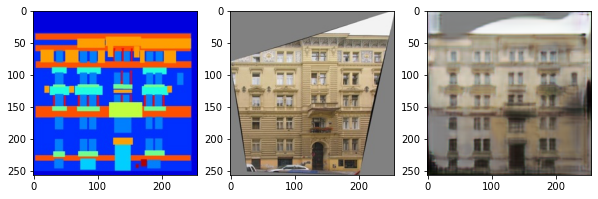

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 40, Generator loss 24.561181297302245, discriminator loss 0.4086943008750677


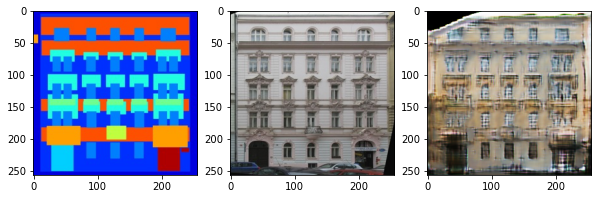

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 60, Generator loss 25.006122703552247, discriminator loss 0.32493545941077173


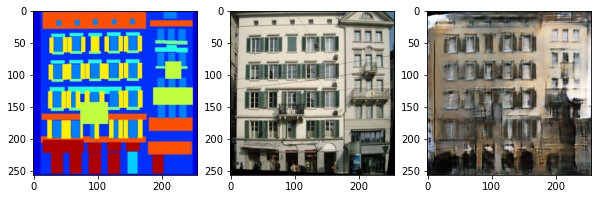

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
trainer.train()

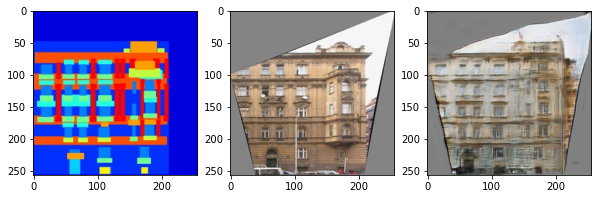

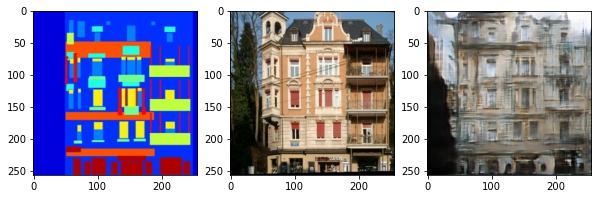

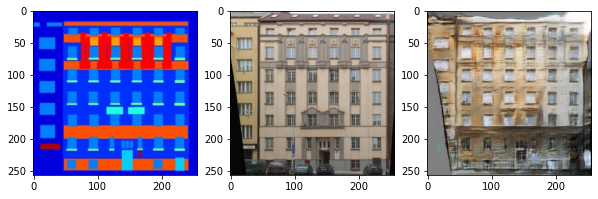

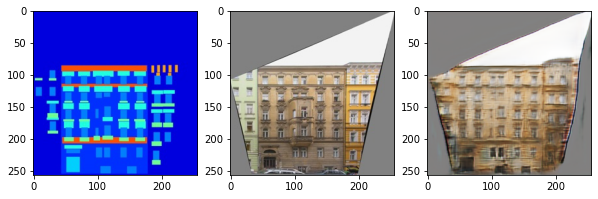

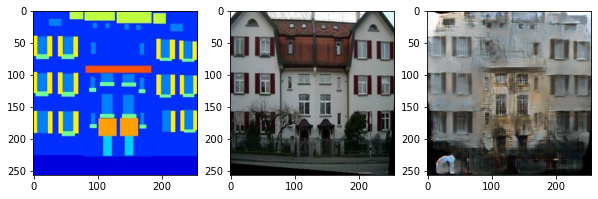

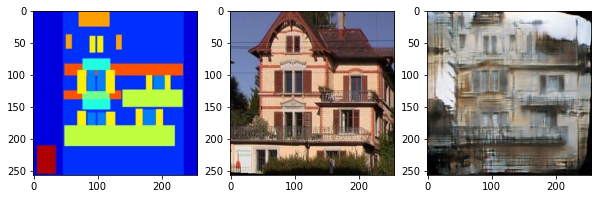

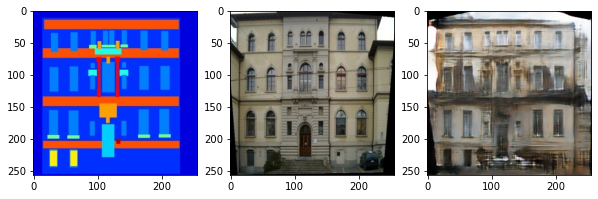

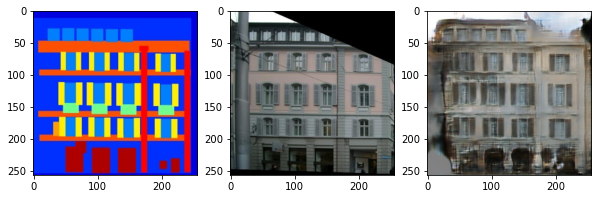

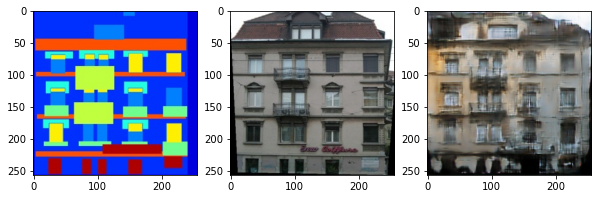

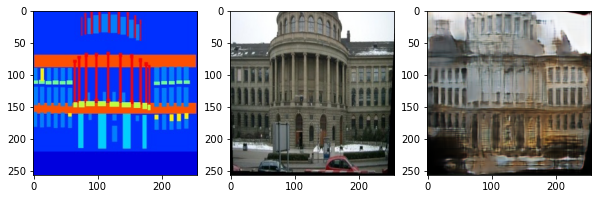

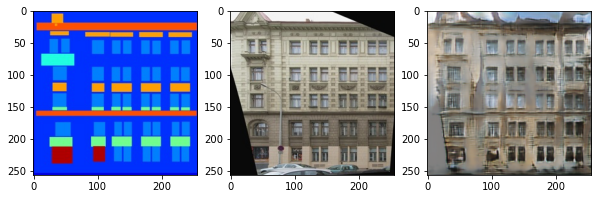

In [10]:
test_dataset = FacadesDataset(TEST_PATH)
test_dataloader = DataLoader(test_dataset, batch_size=confs["batch_size"], shuffle=False)

i = 0
for (real, condition) in test_dataloader:
    fake = generator(condition.to(device)).detach()
    display_progress(condition[0], fake[0], real[0])
    i += 1
    if i > 10:
        break

## Часть вторая: добавим циклы

Вторая часть -- реализация CycleGAN. Предлагается на том же датасете реализовать базовую конструкцию CycleGAN для unpaired style transfer, то есть переноса стилей, каждый из которых задан неразмеченным датасетом (подробнее см. лекцию и собственно Zhu et al., 2017):


In [11]:
class CycleTrainer:
    def __init__(self, generator1, discriminator1, generator2, discriminator2, confs):
        self.generator1 = generator1.to(device)
        self.discriminator1 = discriminator1.to(device)
        
        self.generator2 = generator2.to(device)
        self.discriminator2 = discriminator2.to(device)
        
        self.confs = confs
        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.adversarial_criterion = nn.L1Loss()
        self.recon_criterion = nn.L1Loss()
        
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.generator1.parameters(), 
                                                            self.generator2.parameters()), 
                                            lr=confs["g_lr"], betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(itertools.chain(self.discriminator1.parameters(), 
                                                            self.discriminator2.parameters()), 
                                            lr=confs["d_lr"], betas=(0.5, 0.999))
    
    def generator_train(self, real, condition, generator, discriminator, generator2):
        fake_images = generator(condition)
        disc_logits = discriminator(fake_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

        rec_images = generator2(fake_images)
        cycle_loss = self.recon_criterion(rec_images, condition)

        loss = adversarial_loss + cycle_loss
        
        self.optimizer_G.zero_grad()
        loss.backward()
        self.optimizer_G.step()
        return loss.item()
    
    def discriminator_train(self, real, condition, generator, discriminator):
        fake_images = generator(condition).detach()
        fake_logits = discriminator(fake_images)
        real_logits = discriminator(real)
        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))

        loss = (real_loss + fake_loss) / 2
        
        self.optimizer_D.zero_grad()
        loss.backward()
        self.optimizer_D.step()
        return loss.item()
    
    def train_epoch(self, dataset):
        self.generator1.train()
        self.discriminator1.train()
        self.generator2.train()
        self.discriminator2.train()
        d_losses1 = []
        g_losses1 = []
        d_losses2 = []
        g_losses2 = []
        for (real, condition) in tqdm(dataset):
            real, condition = real.to(device), condition.to(device)
            loss11 = self.generator_train(real, condition, self.generator1, self.discriminator1, self.generator2)
            loss12 = self.generator_train(condition, real, self.generator2, self.discriminator2, self.generator1)
            
            g_losses1.append(loss11)
            g_losses2.append(loss12)
            
            loss21 = self.discriminator_train(real, condition, self.generator1, self.discriminator1)
            loss22 = self.discriminator_train(condition, real, self.generator2, self.discriminator2)
            d_losses1.append(loss21)
            d_losses2.append(loss22)
        return np.mean(g_losses1), np.mean(d_losses1)
    
    def eval(self, dataset):
        for (real, condition) in dataset:
            fake = self.generator1(condition.to(device)).detach()
            display_progress(condition[0], fake[0], real[0])
            break
    
    def train(self):
        train_dataset = FacadesDatasetUnpaired(TRAIN_PATH)
        val_dataset = FacadesDatasetUnpaired(VAL_PATH)
        
        train_dataloader = DataLoader(train_dataset, batch_size=self.confs["batch_size"], shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=self.confs["batch_size"], shuffle=True)
        
        for epoch in range(1, self.confs["num_epochs"]):
            g_loss, d_loss = self.train_epoch(train_dataloader)
            if epoch % 20 == 0:
                print(f"Epoch: {epoch}, Generator loss {g_loss}, discriminator loss {d_loss}")
                self.eval(val_dataloader)

In [12]:
generator_sg1 = Generator()
generator_sg2 = Generator()
discriminator_sg1 = DiscriminatorUP()
discriminator_sg2 = DiscriminatorUP()

In [13]:
device = torch.device("cuda")
confs = {
    "lambda_recon": 200,
    "g_lr": 2e-4, 
    "d_lr": 2e-4,
    "num_epochs": 200,
    "batch_size": 4,
}

trainer = CycleTrainer(generator_sg1, discriminator_sg1, generator_sg2, discriminator_sg2, confs)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20, Generator loss 1.0846739929914475, discriminator loss 0.03668727199546993


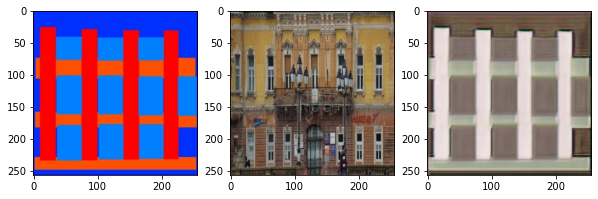

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 40, Generator loss 1.0686406999826432, discriminator loss 0.047095844009891155


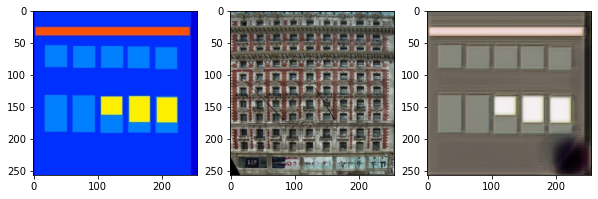

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 60, Generator loss 1.0304137909412383, discriminator loss 0.025101342773996293


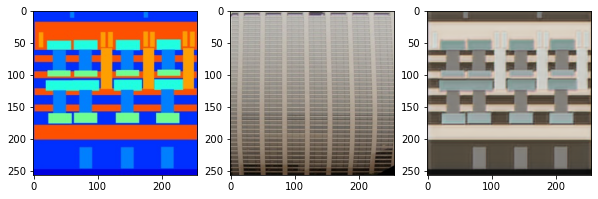

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 80, Generator loss 1.0298571199178697, discriminator loss 0.0246361263981089


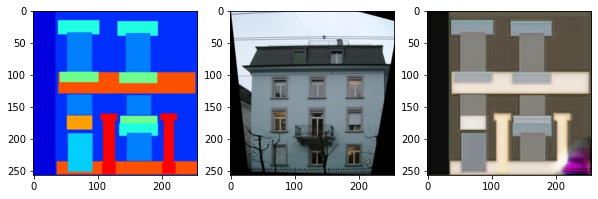

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 100, Generator loss 1.0388714241981507, discriminator loss 0.025921932561323045


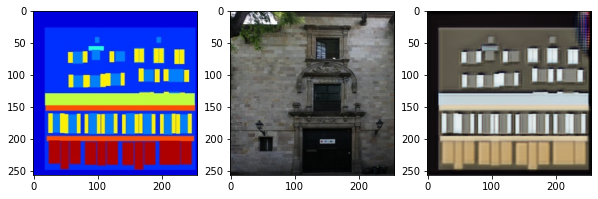

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 120, Generator loss 1.0257564294338226, discriminator loss 0.05393490328453481


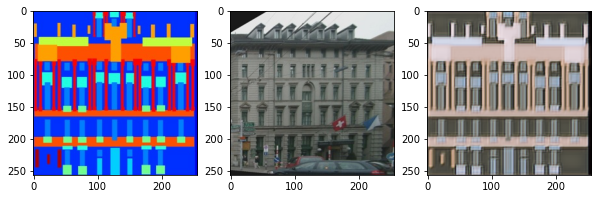

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 140, Generator loss 1.0311501425504686, discriminator loss 0.019631028261501343


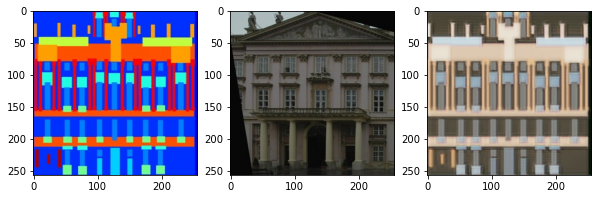

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 160, Generator loss 1.0247619926929474, discriminator loss 0.01856681497534737


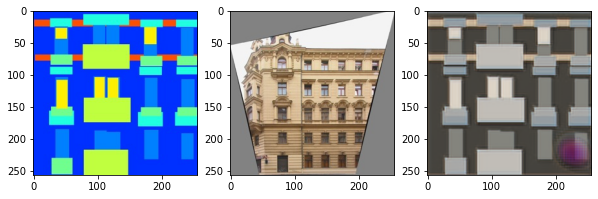

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 180, Generator loss 1.0277614396810533, discriminator loss 0.01796247127465904


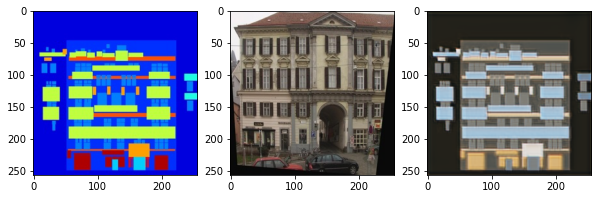

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
trainer.train()

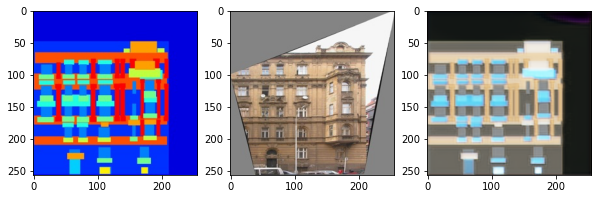

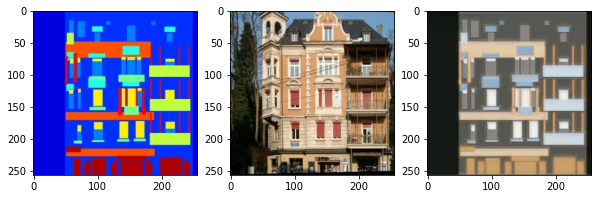

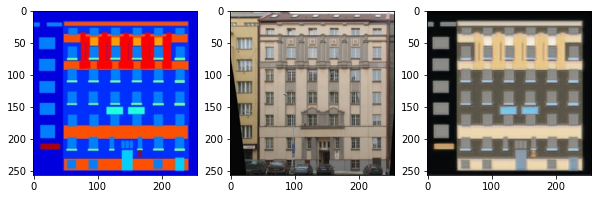

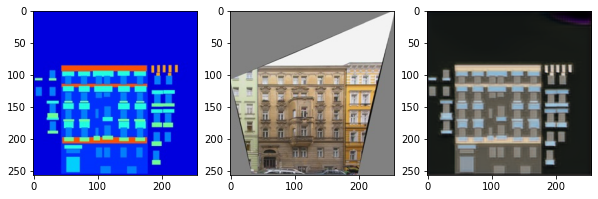

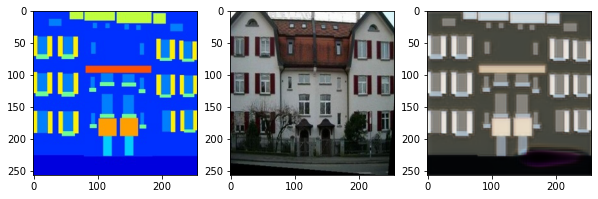

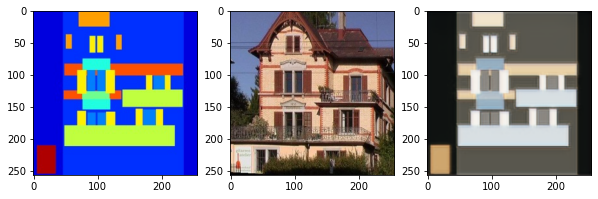

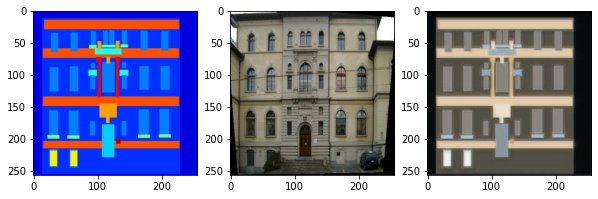

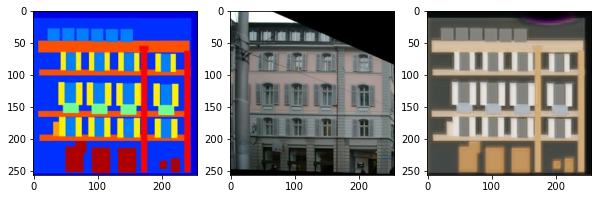

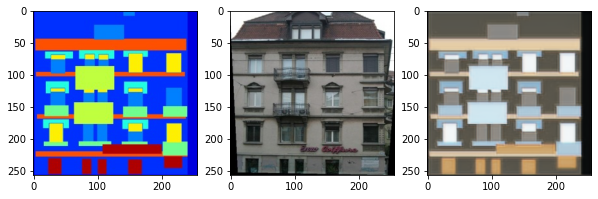

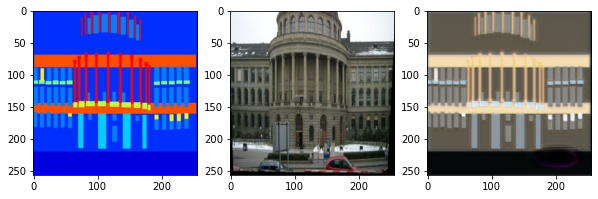

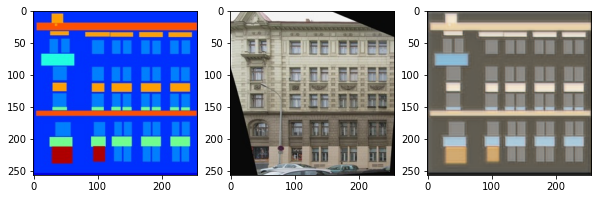

In [15]:
test_dataset = FacadesDataset(TEST_PATH)
test_dataloader = DataLoader(test_dataset, batch_size=confs["batch_size"], shuffle=False)

i = 0
for (real, condition) in test_dataloader:
    fake = generator_sg1(condition.to(device)).detach()
    display_progress(condition[0], fake[0], real[0])
    i += 1
    if i > 10:
        break